In [156]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
# from torchvision.utils import save_image

In [157]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = tv.datasets.MNIST(root='./data',  train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

## 1

#### Contractive loss for regularisation so that small movements in the latent space do no affect the decoded output much



In [158]:
class Autoencoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(3200, hidden_dim),
            )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 400),
            nn.ReLU(True),
            nn.Linear(400, 4000),
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            nn.Sigmoid(),
            )
    def forward(self, x):
        h = self.encoder(x)
        x = self.decoder(h)
        return x, h

    def contractive_loss(self, x, h, x_hat):
        dh = h * (1 - h)
        w = self.encoder[-1].weight
        w = w.view(w.size(1), -1)
        contractive_loss = torch.sum(torch.mm(dh.view(dh.size(0), -1)**2, w.t()**2), dim=1).mean() + nn.MSELoss()(x, x_hat)
        return contractive_loss



In [30]:
model = Autoencoder()
model.encoder[0].weight

Parameter containing:
tensor([[[[ 1.2994e-01,  1.8836e-02,  6.5582e-03, -1.4156e-01,  1.9476e-01],
          [-1.2422e-01,  5.4869e-02,  7.2091e-02, -2.5410e-02, -1.6870e-04],
          [-7.9192e-03,  1.2552e-01, -2.6999e-03, -6.2875e-02, -1.8309e-01],
          [-1.8967e-01,  6.4515e-02, -1.4913e-01, -9.4916e-02,  1.8110e-01],
          [-1.2504e-01, -1.1552e-01, -2.2046e-02,  1.6471e-01, -3.3448e-02]]],


        [[[ 1.3374e-03, -1.2604e-01,  5.4888e-02, -6.7450e-03,  1.3255e-02],
          [-1.0850e-01,  1.0770e-01,  9.4337e-02,  1.8614e-01, -1.8872e-01],
          [-9.8373e-03,  1.5760e-01,  1.5219e-01,  9.7527e-02,  2.5888e-02],
          [-1.1827e-01,  7.5597e-02, -2.0680e-02,  2.5234e-02,  4.0811e-03],
          [ 1.2844e-01, -1.7111e-01, -1.6342e-02, -1.3109e-02,  6.7396e-02]]],


        [[[-1.3470e-01,  1.0098e-01,  1.3669e-01, -5.3321e-02, -9.7627e-02],
          [-1.0950e-01,  1.9365e-01, -6.5380e-02,  9.1942e-03,  5.6317e-02],
          [ 1.4779e-02, -1.0810e-01, -2.5904e-

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 5
torch.manual_seed(42)
model_16 = Autoencoder(16).to(device)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model_16.parameters())

for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, _ = data
        img = Variable(img).to(device)
        output, h = model_16(img)
        loss = model_16.contractive_loss(img, h, output)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1, num_epochs, total_loss.item()))

epoch [1/5], loss: 583.1749
epoch [2/5], loss: 501.6803
epoch [3/5], loss: 492.6980
epoch [4/5], loss: 487.4724
epoch [5/5], loss: 483.7849


In [67]:
model_16.to(device)
with torch.no_grad():
      total_loss = 0
      for data in testloader:
          img, _ = data
          img = Variable(img).to(device)
          output, h = model_16(img)
          loss = distance(img, output)
          total_loss += loss

      print('Test loss: {:.4f}'.format(total_loss.item()))

Test loss: 81.1030


In [149]:
num_epochs = 5
torch.manual_seed(50)
model_32 = Autoencoder(32).to(device)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model_32.parameters(), lr = 0.001)


for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, _ = data
        img = Variable(img).to(device)
        output, h = model_32(img)
        loss = model_32.contractive_loss(img, h, output)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1, num_epochs, total_loss.item()))

epoch [1/5], loss: 597.7883
epoch [2/5], loss: 484.1087
epoch [3/5], loss: 471.0617
epoch [4/5], loss: 465.3890
epoch [5/5], loss: 462.3695


In [159]:
model_32.to(device)
with torch.no_grad():
      total_loss = 0
      for data in testloader:
          img, _ = data
          img = Variable(img).to(device)
          output, h = model_32(img)
          loss = distance(img, output)
          total_loss += loss

      print('Test loss: {:.4f}'.format(total_loss.item()))

Test loss: 77.7124


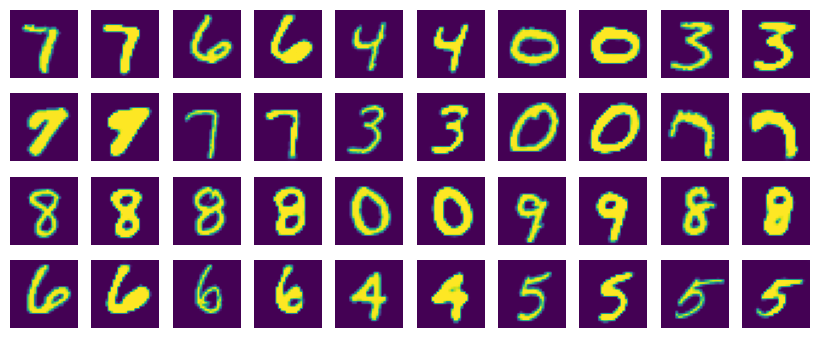

In [151]:
images = []
model_16 = model_16.to("cpu")

for data in testloader:
    temp = data
    break
img, _ = temp
# print(img.shape)
# img = Variable(img).to(device)
for i in range(10):

  images.append(img[i])
  images.append(model_16(img[i].unsqueeze(0))[0].squeeze().detach().numpy())

for data in dataloader:
    temp = data
    break

gradient_pairs = []
img, _ = temp
# print(img.shape)
# img = Variable(img).to(device)
for i in range(10):

  images.append(img[i])
  images.append(model_16(img[i].unsqueeze(0))[0].squeeze().detach().numpy())

ncols = 10
nrows = 2

fig, axes = plt.subplots(nrows=4, ncols=ncols, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze())
    ax.axis('off')
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
plt.show()

#### 10 Images from the training dataset and 10 from testing, on the left is the input with the reconstruction on the right

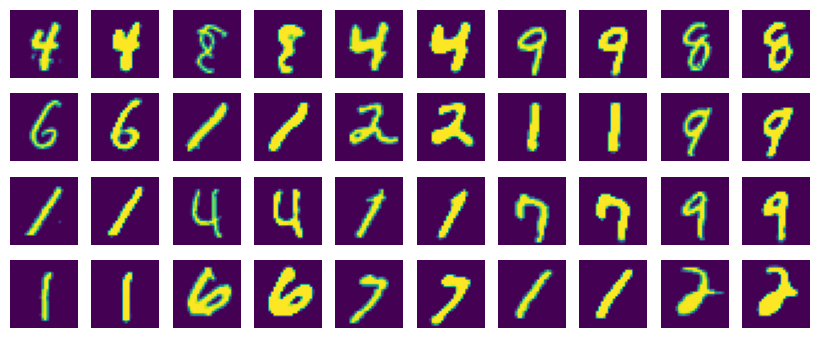

In [152]:
images = []
model_32 = model_32.to("cpu")

for data in testloader:
    temp = data
    break
img, _ = temp
# print(img.shape)
# img = Variable(img).to(device)
for i in range(10):

  images.append(img[i])
  images.append(model_32(img[i].unsqueeze(0))[0].squeeze().detach().numpy())

for data in dataloader:
    temp = data
    break

img, _ = temp
# print(img.shape)
# img = Variable(img).to(device)
for i in range(10):

  images.append(img[i])
  images.append(model_32(img[i].unsqueeze(0))[0].squeeze().detach().numpy())

ncols = 10
nrows = 2

fig, axes = plt.subplots(nrows=4, ncols=ncols, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze())
    ax.axis('off')
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
plt.show()

#### 10 Images from the training dataset and 10 from testing, on the left is the input with the reconstruction on the right

<Figure size 640x480 with 0 Axes>

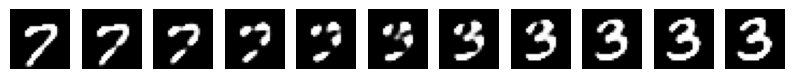

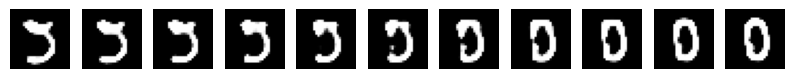

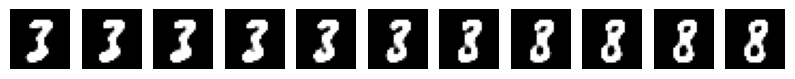

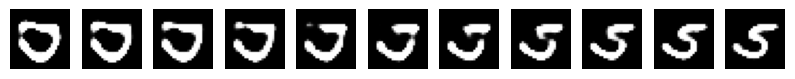

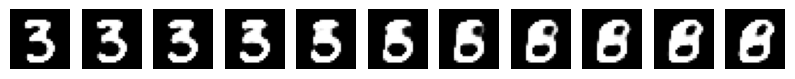

In [164]:
import random
num_samples = len(trainset)
model_32 = model_32.to("cpu")
for i in range(5):
    index1 = random.randint(0, num_samples - 1)
    index2 = random.randint(0, num_samples - 1)

    sample1 = trainset[index1][0]
    sample2 = trainset[index2][0]

    encoded_sample1 = model_32.encoder(sample1.unsqueeze(0))
    encoded_sample2 = model_32.encoder(sample2.unsqueeze(0))

    gap = encoded_sample2 - encoded_sample1

    step_size = gap / 12.0
    intermediate_steps = [encoded_sample1 + i*step_size for i in range(1, 12)]

    decoded_steps = [model_32.decoder(step) for step in intermediate_steps]

    plt.figure(i)
    plt.figure(figsize=(10, 10))

    for j, img in enumerate(decoded_steps):
        img = img.detach().numpy().reshape((28, 28))

        plt.subplot(1, len(decoded_steps), j+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
plt.show()

## 2.

In [124]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            nn.Flatten(),
            )
        self.L_mu = nn.Linear(3200, 16)
        self.L_logvar = nn.Linear(3200, 16)
        self.decoder = nn.Sequential(
            nn.Linear(16, 400),
            nn.ReLU(True),
            nn.Linear(400, 4000),
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            nn.Sigmoid(),
            )

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        mu, log_var = self.L_mu(self.encoder(x)), self.L_logvar(self.encoder(x))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [125]:
def loss_fn(x, x_hat, mean, logvar):
  mse=torch.mean(torch.square(x_hat-x))
  kld=-0.5*torch.sum(1+logvar-mean.pow(2)-logvar.exp())
  return mse+kld

In [139]:
num_epochs = 5
torch.manual_seed(50)
model = VAE().to(device)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)


for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, _ = data
        img = Variable(img).to(device)
        output, mean, logvar = model(img)
        loss = loss_fn(img, output, mean, logvar)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1, num_epochs, total_loss.item()))

epoch [1/5], loss: 1511.9628
epoch [2/5], loss: 754.1580
epoch [3/5], loss: 753.5802
epoch [4/5], loss: 753.4763
epoch [5/5], loss: 753.5046


In [140]:
model = model.to(device)
with torch.no_grad():
      total_loss = 0
      for data in testloader:
          img, _ = data
          img = Variable(img).to(device)
          output, _, _ = model(img)
          loss = distance(img, output)
          total_loss += loss

      print('Test loss: {:.4f}'.format(total_loss.item()))

Test loss: 126.7045


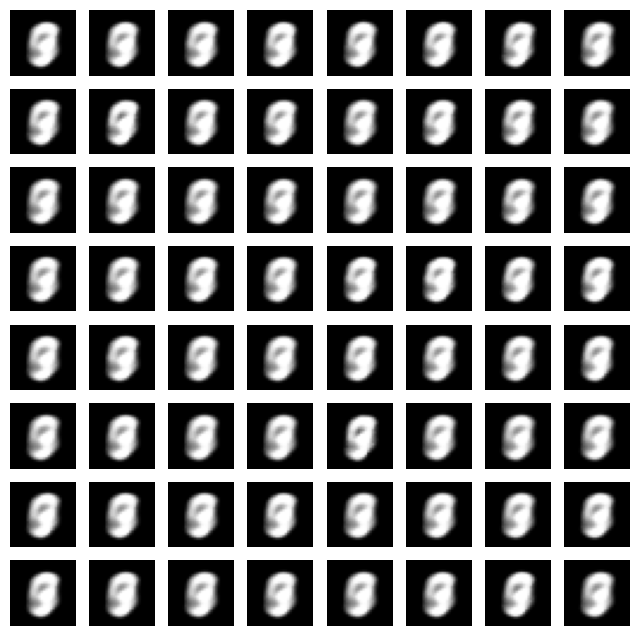

In [141]:
model = model.to("cpu")
fig, axs = plt.subplots(8, 8, figsize=(8, 8))

for i in range(8):
    for j in range(8):
        z = torch.randn(1, 16)

        reconstructed_img = model.decoder(z)


        reconstructed_img = reconstructed_img.squeeze().detach().numpy()

        axs[i, j].imshow(reconstructed_img, cmap='gray')
        axs[i, j].axis('off')

plt.show()